# OPERA DISP-S1 Part 2: Extracting time series 


Now we will look at [California Frame 11116](https://displacement.asf.alaska.edu/#/?dispOverview=VEL&zoom=10.071&center=-120.356,35.799&start=2016-07-15T04:45:05Z&end=2024-11-30T05:45:45Z&series=POINT(-120.67903828400804%2036.036692067974656)--5--Point--33e48003-99bd-460c-a425-e048c600f01b--Series::POINT(-120.2712490037294%2036.195149421726015)--6--Point--798d25d4-7b5e-40d4-8b40-ac45dae56de6--Series&flightDirs=DESCENDING), with fault movement, subsidence, landslides


A reminder of the salient features of OPERA DISP-S1 products:

- Frame-based, spatial footprint is fixed over time
- Displacement given in the radar line-of-sight (LOS), where positive means "towards the satellite"
- Geocoded on a UTM grid (different frames may be in different UTM zones)
- Solid Earth Tide and Ionospheric range-delay corrections included (but not applied by default)
- Data format: Cloud optimized NetCDF (HDF5-compatible)

In [10]:
from pathlib import Path

In [1]:
%%bash
time opera-utils disp-s1-download \
    --output-dir opera-subset-CA \
    --frame-id 11116  \
    --bbox -120.68 36.0 -120.285 36.2 \
    --start-datetime 2020-01-01 \
    --end-datetime 2022-01-01 \
    --url-type S3 --num-workers 4 

Found 120 urls for Frame 11116
Subsetting to Rows: slice(3529, 4238, None), cols: slice(6959, 8164, None)
100%|██████████| 120/120 [09:38<00:00,  4.82s/it]

real	9m47.158s
user	8m36.008s
sys	0m17.742s


Note that the subset mentioned it was getting `Rows: slice(3529, 4238, None), cols: slice(6959, 8164, None)`.
This means the output shape will be `(709, 1205)`

## Adjusting the moving reference date

Due to the production system of the OPERA Displacement products, the "reference date" for the outputs moves forward in time. This means that plotting one pixel's time series directly from the output products will lead to "zigzag" results.

In [2]:
!ls opera-subset-CA | head

OPERA_L3_DISP-S1_IW_F11116_VV_20191105T140736Z_20200104T140734Z_v1.0_20250410T091243Z.nc
OPERA_L3_DISP-S1_IW_F11116_VV_20191105T140736Z_20200110T140816Z_v1.0_20250410T091243Z.nc
OPERA_L3_DISP-S1_IW_F11116_VV_20191105T140736Z_20200122T140815Z_v1.0_20250410T091243Z.nc
OPERA_L3_DISP-S1_IW_F11116_VV_20191105T140736Z_20200128T140733Z_v1.0_20250410T091243Z.nc
OPERA_L3_DISP-S1_IW_F11116_VV_20191105T140736Z_20200203T140815Z_v1.0_20250410T091243Z.nc
OPERA_L3_DISP-S1_IW_F11116_VV_20191105T140736Z_20200209T140733Z_v1.0_20250410T091243Z.nc
OPERA_L3_DISP-S1_IW_F11116_VV_20200209T140733Z_20200215T140814Z_v1.0_20250410T152526Z.nc
OPERA_L3_DISP-S1_IW_F11116_VV_20200209T140733Z_20200221T140733Z_v1.0_20250410T152526Z.nc
OPERA_L3_DISP-S1_IW_F11116_VV_20200209T140733Z_20200227T140814Z_v1.0_20250410T152526Z.nc
OPERA_L3_DISP-S1_IW_F11116_VV_20200209T140733Z_20200304T140733Z_v1.0_20250410T152526Z.nc


We see that the first datetime in the filenames changes, indicating the reference has moved forward.

However, this does not mean an "inversion" is necessary, only a "cumulative sum" of the displacement.

In [3]:
%%bash
time opera-utils disp-s1-reformat \
    --reference-method BORDER \
    --no-apply-solid-earth-corrections \
    --output-name opera-subset-CA-stack.nc \
    --input-files opera-subset-CA/OPERA*.nc

/home/jovyan/.local/envs/dolphin_env/lib/python3.12/site-packages/opera_utils/disp/_reformat.py:173: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(use_new_combine_kwarg_defaults=True) or set data_vars explicitly.
  ds = xr.open_mfdataset(dps.filenames, engine="h5netcdf", chunks=process_chunk_dict)
/home/jovyan/.local/envs/dolphin_env/lib/python3.12/site-packages/opera_utils/disp/_reformat.py:174: FutureWarning: In a future version of xarray the default value for data_vars will change from data_vars='all' to data_vars=None. This is likely to lead to different results when multiple datasets have matching variables with overlapping values. To opt in to new defaults and get rid of these warnings now use `set_options(us

Wrote minimal dataset: <xarray.Dataset> Size: 3MB
Dimensions:                 (time: 120, y: 709, x: 1205)
Coordinates:
  * y                       (y) float64 6kB 4.009e+06 4.009e+06 ... 3.987e+06
  * x                       (x) float64 10kB 7.086e+05 7.086e+05 ... 7.447e+05
  * time                    (time) datetime64[ns] 960B 2020-01-04T14:07:34.49...
Data variables:
    spatial_ref             (time) int64 960B 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0
    reference_time          (time) datetime64[ns] 960B dask.array<chunksize=(1,), meta=np.ndarray>
    water_mask              (y, x) float32 3MB dask.array<chunksize=(709, 1205), meta=np.ndarray>
    perpendicular_baseline  (time) float32 480B dask.array<chunksize=(1,), meta=np.ndarray>
Attributes:
    Conventions:         CF-1.8
    contact:             opera-sds-ops@jpl.nasa.gov
    institution:         NASA JPL
    mission_name:        OPERA
    reference_document:  JPL D-108765
    title:               OPERA_L3_DISP-S1 Product
 in 15.4


real	2m34.968s
user	2m32.796s
sys	0m3.151s


In [ ]:
import ultraplot as uplt
import xarray as xr

# %matplotlib widget # for interactive plots
%matplotlib inline

In [5]:
uplt.rc["image.cmap"] = "RdBu_r"
uplt.rc["image.interpolation"] = "nearest"

In [7]:
ds = xr.open_dataset("opera-subset-CA-stack.nc")
ds

<xarray.Dataset> Size: 4GB
Dimensions:                         (time: 120, y: 709, x: 1205)
Coordinates:
    spatial_ref                     (time) int64 960B ...
  * y                               (y) float64 6kB 4.009e+06 ... 3.987e+06
  * x                               (x) float64 10kB 7.086e+05 ... 7.447e+05
  * time                            (time) datetime64[ns] 960B 2020-01-04T14:...
Data variables: (12/14)
    reference_time                  (time) datetime64[ns] 960B ...
    water_mask                      (y, x) float32 3MB ...
    perpendicular_baseline          (time) float32 480B ...
    temporal_coherence              (time, y, x) float32 410MB ...
    phase_similarity                (time, y, x) float32 410MB ...
    persistent_scatterer_mask       (time, y, x) float32 410MB ...
    ...                              ...
    recommended_mask                (time, y, x) float32 410MB ...
    estimated_phase_quality         (time, y, x) float32 410MB ...
    shp_counts                      (time, y, x) float32 410MB ...
    average_temporal_coherence      (y, x) float32 3MB ...
    displacement                    (time, y, x) float32 410MB ...
    short_wavelength_displacement   (time, y, x) float32 410MB ...
Attributes:
    Conventions:         CF-1.8
    contact:             opera-sds-ops@jpl.nasa.gov
    institution:         NASA JPL
    mission_name:        OPERA
    reference_document:  JPL D-108765
    title:               OPERA_L3_DISP-S1 Product

Let's plot the results and see what the cumulative displacement looks like:

In [63]:
da_last = ds.displacement[-1]

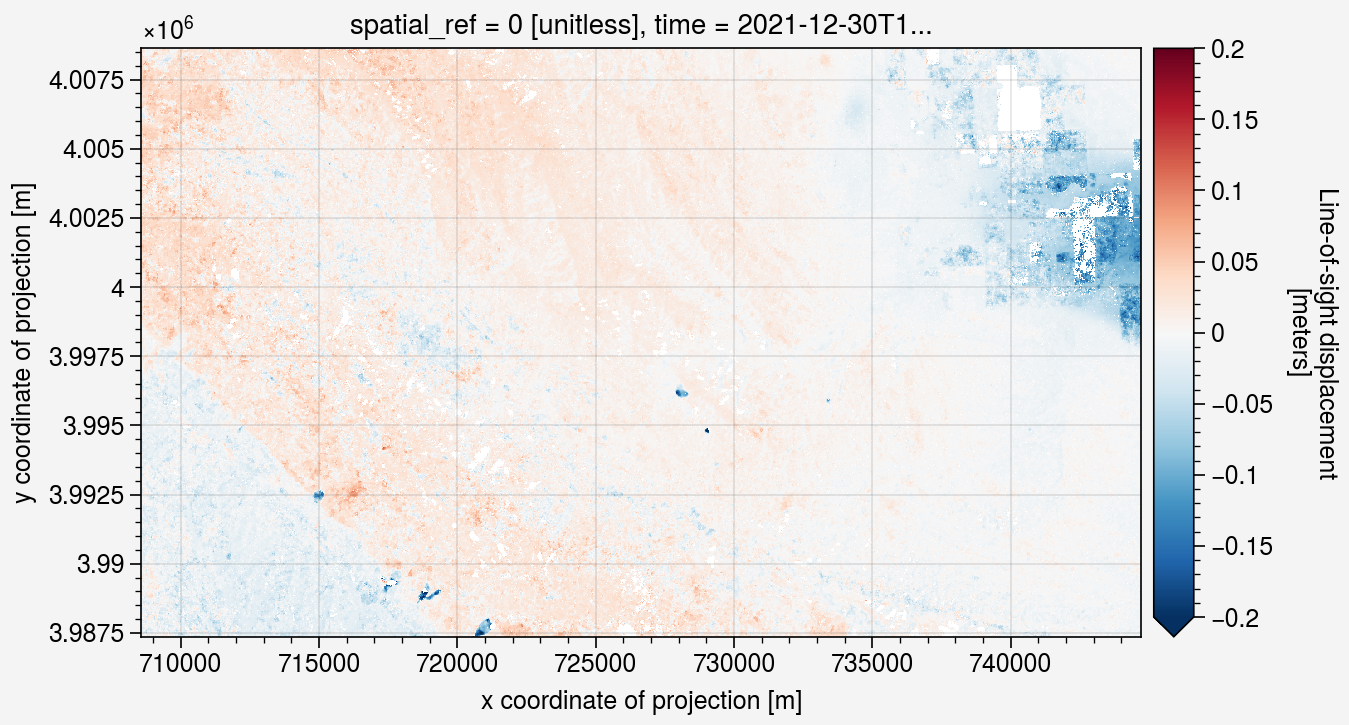

In [64]:
fig, ax = uplt.subplots(refwidth=5)
da_last.plot.imshow(ax=ax, vmax=0.2, vmin=-0.2, cmap="RdBu_r")
ax.set_aspect("equal")

If we want a stricter mask, but a nice looking plot without much nodata, we can `coarsen` the results:

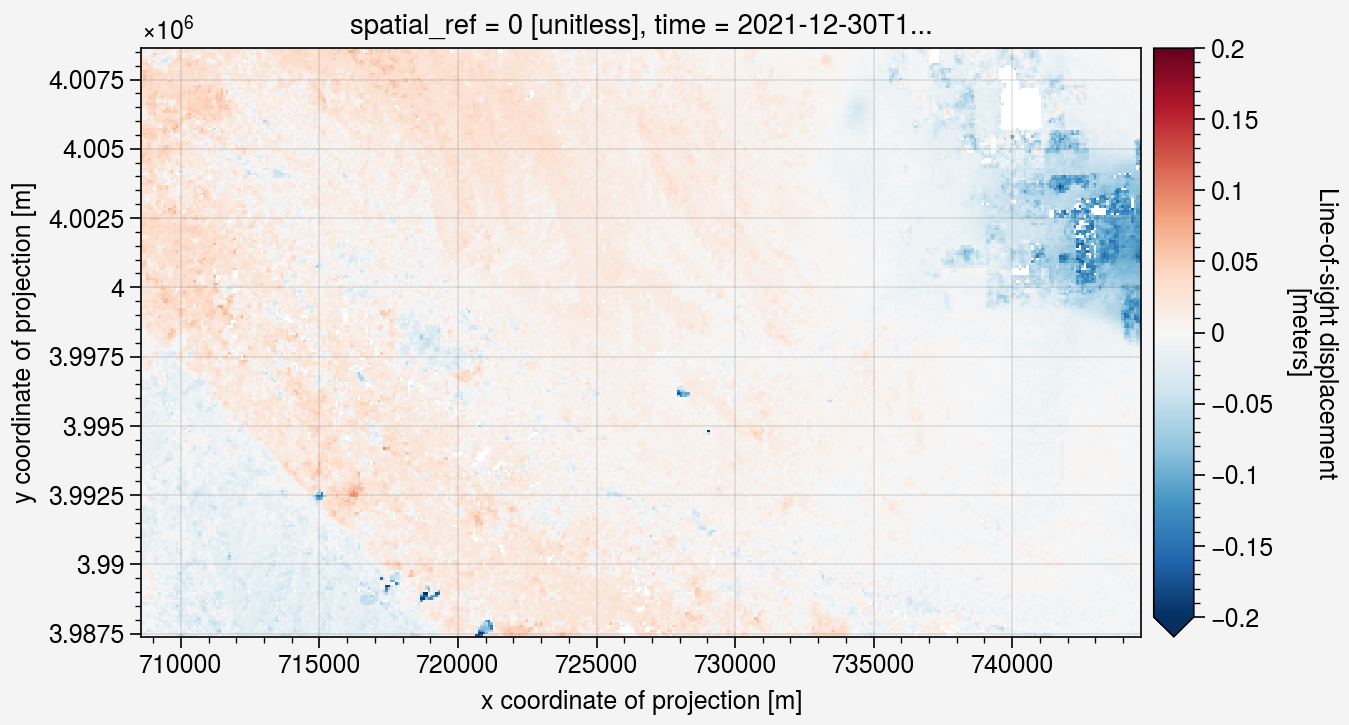

In [66]:
strict_mask = (ds.temporal_coherence[-1] > 0.75) | (ds.phase_similarity[-1] > 0.6)

da_last_coarse = (
    # Apply the stricter mask
    da_last.where(strict_mask)
    # Coarsen 3 by 3 to make a 90 meter image
    .coarsen(x=3, y=3, boundary="trim")
    # Take the nan-aware median of each 3x3 window
    .median()
)
fig, ax = uplt.subplots(refwidth=5)
da_last_coarse.plot.imshow(ax=ax, vmax=0.2, vmin=-0.2, cmap="RdBu_r")
ax.set_aspect("equal")

## Plotting a time series

Since our points are in lat/lon, we want to find the pixel locations in the UTM grid.
We can reproject the UTM data with `rioxarray`:

In [67]:
da_displacement_latlon = ds.displacement.rio.reproject("EPSG:4326")

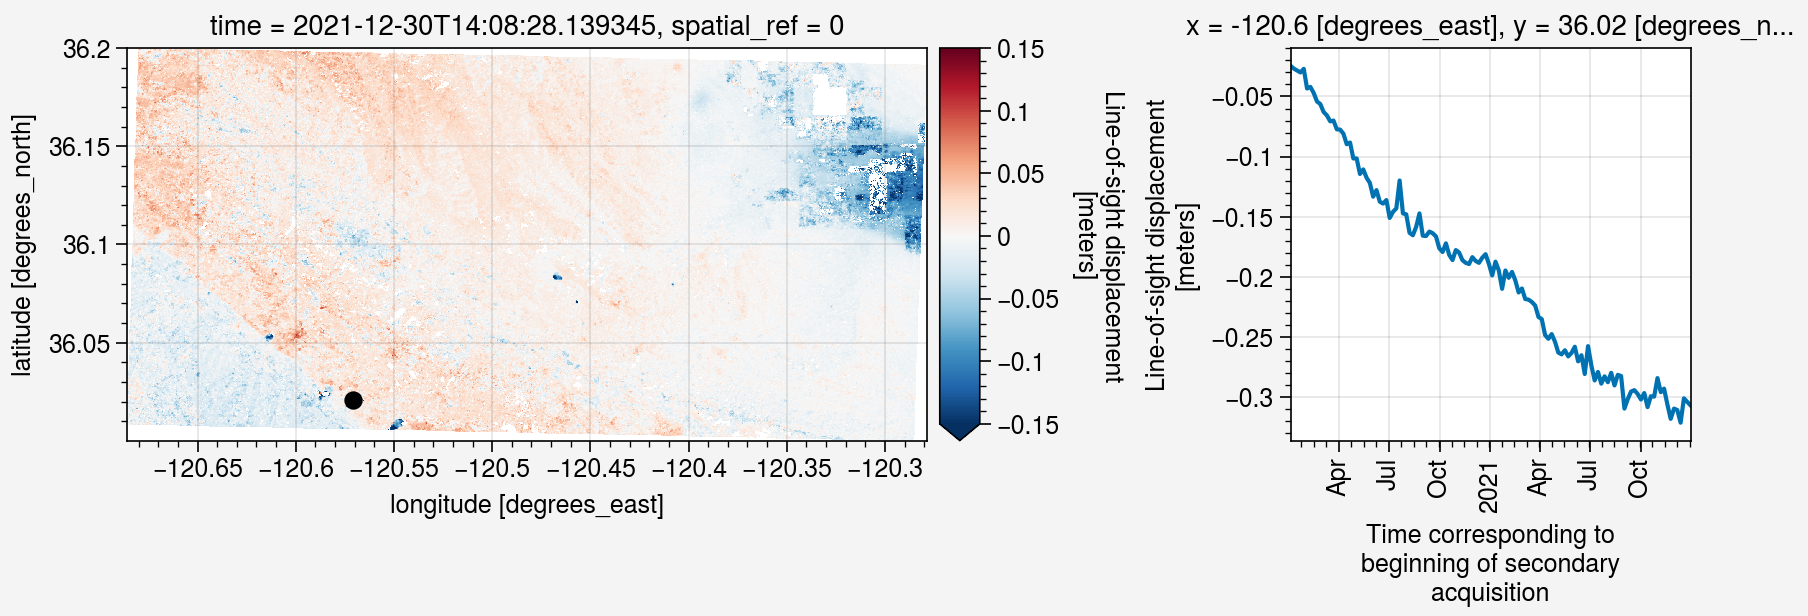

In [68]:
lon, lat = -120.57096658, 36.02059686
da_time_series = da_displacement_latlon.sel(x=lon, y=lat, method="nearest")

fig, axes = uplt.subplots(refwidth=4, wratios=(2, 1), ncols=2, share=False)
da_time_series.plot(ax=axes[1])

da_displacement_latlon[-1].plot.imshow(ax=axes[0], vmax=0.15, vmin=-0.15, cmap="RdBu_r")
axes[0].scatter(x=lon, y=lat, marker="o", color="black")
axes[0].set_aspect("equal")


Another way to get row/column location is to use the "inverse transform", if you don't want to warp your displacement data itself:

In [79]:
utm_epsg = ds.displacement.rio.crs.to_epsg()
print(f"Current product EPSG code: {utm_epsg}")

Current product EPSG code: 32610


In [85]:
from pyproj import Transformer

t_lonlat_utm = Transformer.from_crs(4326, utm_epsg, always_xy=True)
x_utm, y_utm = t_lonlat_utm.transform(lon, lat)
print(f"UTM Coordinates: {x_utm:.2f}, {y_utm:.2f}")

col, row = (~ds.displacement.rio.transform()) * (x_utm, y_utm)
print(f"{int(row) = }, {int(col) = }")

UTM Coordinates: 718886.46, 3988962.46
int(row) = 655, int(col) = 343


The opera-utils package provides a convenience function for doing this lat/lon -> UTM -> row, column conversion:

In [70]:
import opera_utils.disp

# Create the object which is aware of the coordinates of the OPER Adata
dps = opera_utils.disp.DispProductStack.from_file_list(
    Path("opera-subset-CA/").glob("*.nc")
)
# Convert longitude/latitude to row/column
dps.lonlat_to_rowcol(lon, lat)

(656, 344)